## Training Model

### how can we predict multiple swell heights and directions? 

- each time stamp (every 30 minutes) has the dominant swell height. We want to predict this
- for a 1 day prediction. get all the data as late as one day ago, and this is a data point with many dimensions. Maybe grab a snapshot of each buoy from 
- encode this into a large vector. Use WvHT (waveheight), MWD (main swell direction in degrees), ans SwP as prediction. 
- using a neural network is a good solution, because the data is high dimensional and non linear

In [1]:
import torch
import pandas as pd
import sqlite3
import numpy as np
import functions

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from datetime import datetime

In [81]:
conn = sqlite3.connect('db.db')
data = pd.read_sql_query("SELECT * from main", conn)
data = functions.cleanData(data)

target = functions.buildnparray(data[data["buoy_id"] == "46221"])
data = functions.buildnparray(data[data["buoy_id"] != "46221"])

# data = functions.buildnparray(functions.cleanData(data))
data = data[1:]

(1487, 1, 3)
(1488, 75, 3)


### parameters and building data

In [63]:
sequence_length = 24 * 10  # length of sequence, 24 hours * 10 days
batch_size = 32      # Batch size for training
num_epochs = 100      # Number of training epochs

In [4]:
def intoTensor(data):
    data_tensor = torch.Tensor(data) # convert to pytorch tensor

    data_tensor = torch.reshape(data_tensor, (data.shape[0], -1))
    nan_mask = torch.isnan(data_tensor)
    data_tensor[nan_mask] = 0
    return data_tensor

In [6]:
data = intoTensor(data)
target = intoTensor(target)

In [8]:
data_test = data[int(len(data) * 0.75):, :]
data_train = data[:int(len(data) * 0.75), :]

target_test = target[int(len(target) * 0.75):, :]
target_train = target[:int(len(target) * 0.75), :]

In [82]:
# Create input sequences and corresponding target values
# want to predict 24 hours ahead

def buildTensor(data_tensor, target_tensor, batch_size = batch_size):
    input_sequences = []
    target_values = []

    for i in range(len(data_tensor) - sequence_length - 24):
        input_seq = data_tensor[i:i+sequence_length]
        target_val = target_tensor[i + sequence_length + 24]
        # input_seq = data_tensor[i:i+sequence_length]  
        # target_val = data_tensor[i+sequence_length] 
        input_sequences.append(input_seq)
        target_values.append(target_val)
    # print("input sequences", input_sequences.shape)

    input_sequences = torch.stack(input_sequences)
    target_values = torch.stack(target_values)

    dataset = TensorDataset(input_sequences, target_values)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return (dataset, dataloader)

dataset, dataloader = buildTensor(data_train, target_train)

In [71]:
class WaveForecastingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WaveForecastingRNN, self).__init__()
        # self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # recurrent neural network
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # long short term memory model
        self.fc = nn.Linear(hidden_size, output_size) # fully connected layer
        # self.fc = nn.Linear(hidden_size, output_size) # fully connected layer


    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last time step's output for prediction
        return out

### Training

In [72]:
num_features = 225
input_size = num_features
hidden_size = 64
num_layers = 1 
output_size = 3
# output_size = num_features

loss_errors = []

model = WaveForecastingRNN(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start = datetime.now() # timing
# Training loop
print(f'beginning training')
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_errors.append(loss.item())
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
end = datetime.now() # timing end

print(f"training finished in {end - start}, saving model")
torch.save(model.state_dict(), 'model_weights.pth')


beginning training
Epoch [1/100], Loss: 13184.1445
Epoch [11/100], Loss: 12472.1553
Epoch [21/100], Loss: 11817.4990
Epoch [31/100], Loss: 11191.5918
Epoch [41/100], Loss: 10590.0732
Epoch [51/100], Loss: 10011.2305
Epoch [61/100], Loss: 9453.9316
Epoch [71/100], Loss: 8917.2705
Epoch [81/100], Loss: 8400.4619
Epoch [91/100], Loss: 7842.2065
training finished in 0:02:24.347405, saving model


In [74]:
iterations = range(1, len(loss_errors) + 1)

In [75]:
# loss_errors = list(map(lambda x: x.detach().numpy(), loss_errors))
# loss_errors = loss_errors.detach().numpy()

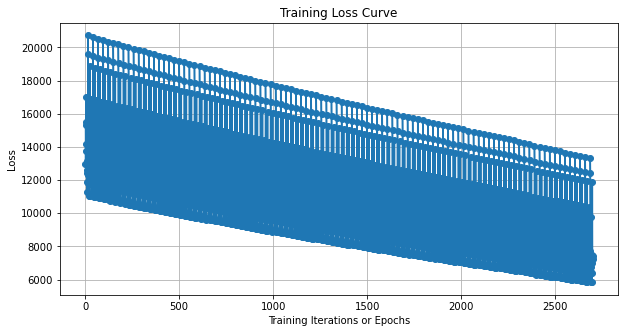

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(iterations, loss_errors, marker='o', linestyle='-')
plt.title('Training Loss Curve')
plt.xlabel('Training Iterations or Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Testing

In [77]:
model = WaveForecastingRNN(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

WaveForecastingRNN(
  (rnn): LSTM(225, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [78]:
target_test.shape

torch.Size([372, 3])

In [79]:
datasettest, dataloadertest = buildTensor(data_test, target_test, batch_size = 1)

In [83]:
test_loss = 0.0
for inputs, targets in dataloadertest:
    # Forward pass
    print(inputs.shape)
    outputs = model(inputs)
    # print("outputs: ", outputs, "\n", "targets: ", targets, "\n")
    
    # Compute loss
    loss = criterion(outputs, targets)
    # print("loss:  ", loss)
    test_loss += loss.item()  # Accumulate the test loss

# Calculate and print average test loss
avg_test_loss = test_loss / len(dataloadertest)
print(f'Average Test Loss: {avg_test_loss:.4f}')

torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([1, 240, 225])
torch.Size([